In [236]:
import numpy as np
import os
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import models, transforms, datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [237]:
bs=1 # suggested by the paper
lr=0.0002
beta1=0.5
beta2=0.999
NUM_EPOCHS = 50
ngpu = 1
L1_lambda = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [238]:
import numpy as np
import os
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import models, transforms, datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

bs = 32  # Define the batch size here

# Define data transformations
data_transform = transforms.Compose([
    transforms.Resize((254, 254)),
    transforms.ToTensor()
])

# Define the data directory
data_dir = "C:\\Users\\cl502_04\\Downloads\\train1\\train1"

# Load datasets
dataset_train = datasets.ImageFolder(root=os.path.join(data_dir, "C:\\Users\\cl502_04\\Downloads\\train1\\train1"), transform=data_transform)
dataset_val = datasets.ImageFolder(root=os.path.join(data_dir, "C:\\Users\\cl502_04\\Downloads\\train1\\train1"), transform=data_transform)

# Create data loaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=bs, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=24, shuffle=True, num_workers=0)



In [239]:
print(len(dataset_train))
print(len(dataset_val))

2192
2192


In [240]:
def show_image(img, title="No title", figsize=(5,5)):
    img = img.numpy().transpose(1,2,0)
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])

    img = img * std + mean
    np.clip(img, 0, 1)

    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.title(title)

In [241]:
images,_ = next(iter(dataloader_train))

sample_sat = images[0][:,:,:256]
sample_map = images[0][:,:,120:]

In [242]:
sample_map

tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.8196, 0.8196, 0.8196,  ..., 0.8196, 0.8196, 0.8196],
         [0.8196, 0.8196, 0.8196,  ..., 0.8196, 0.8196, 0.8196],
         [0.8196, 0.8196, 0.8196,  ..., 0.8196, 0.8196, 0.8196],
         ...,
         [0.8196, 0.8196, 0.8196,  ..., 0.8196, 0.8196, 0.8196],
         [0.8196, 0.8196, 0.8196,  ..., 0.8196, 0.8196, 0.8196],
         [0.8196, 0.8196, 0.8196,  ..., 0.8196, 0.8196, 0.8196]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.

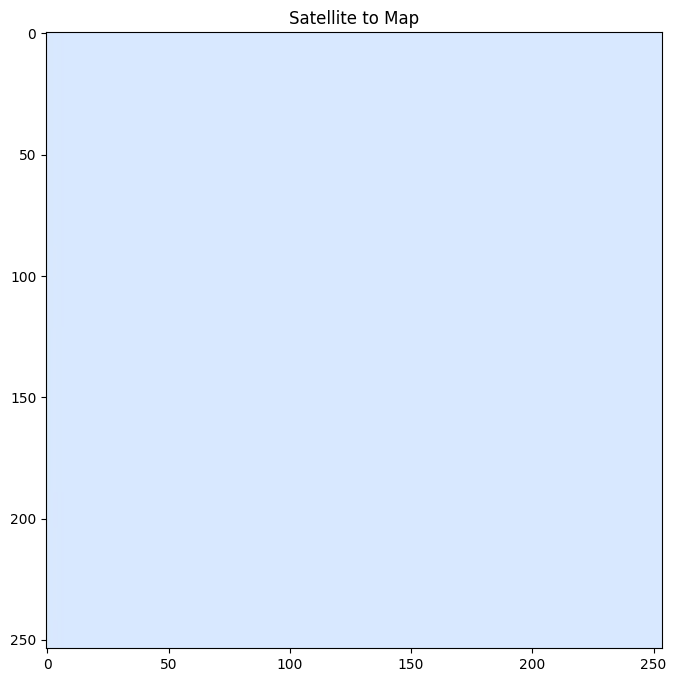

In [243]:
show_image(images[0], title="Satellite to Map", figsize=(8,8))

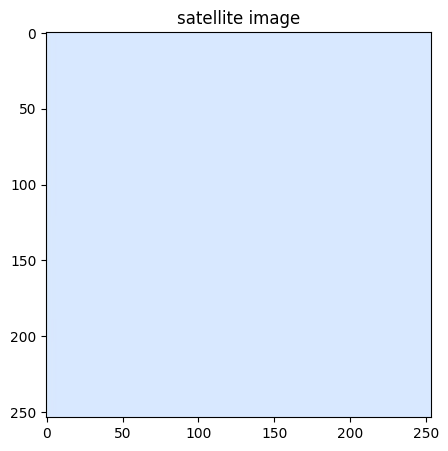

In [244]:
show_image(img = sample_sat, title = "satellite image", figsize=(5,5))

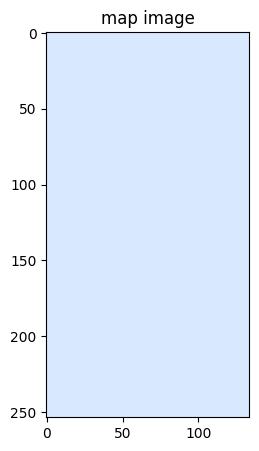

In [245]:
show_image(img = sample_map, title = "map image", figsize=(5, 5))

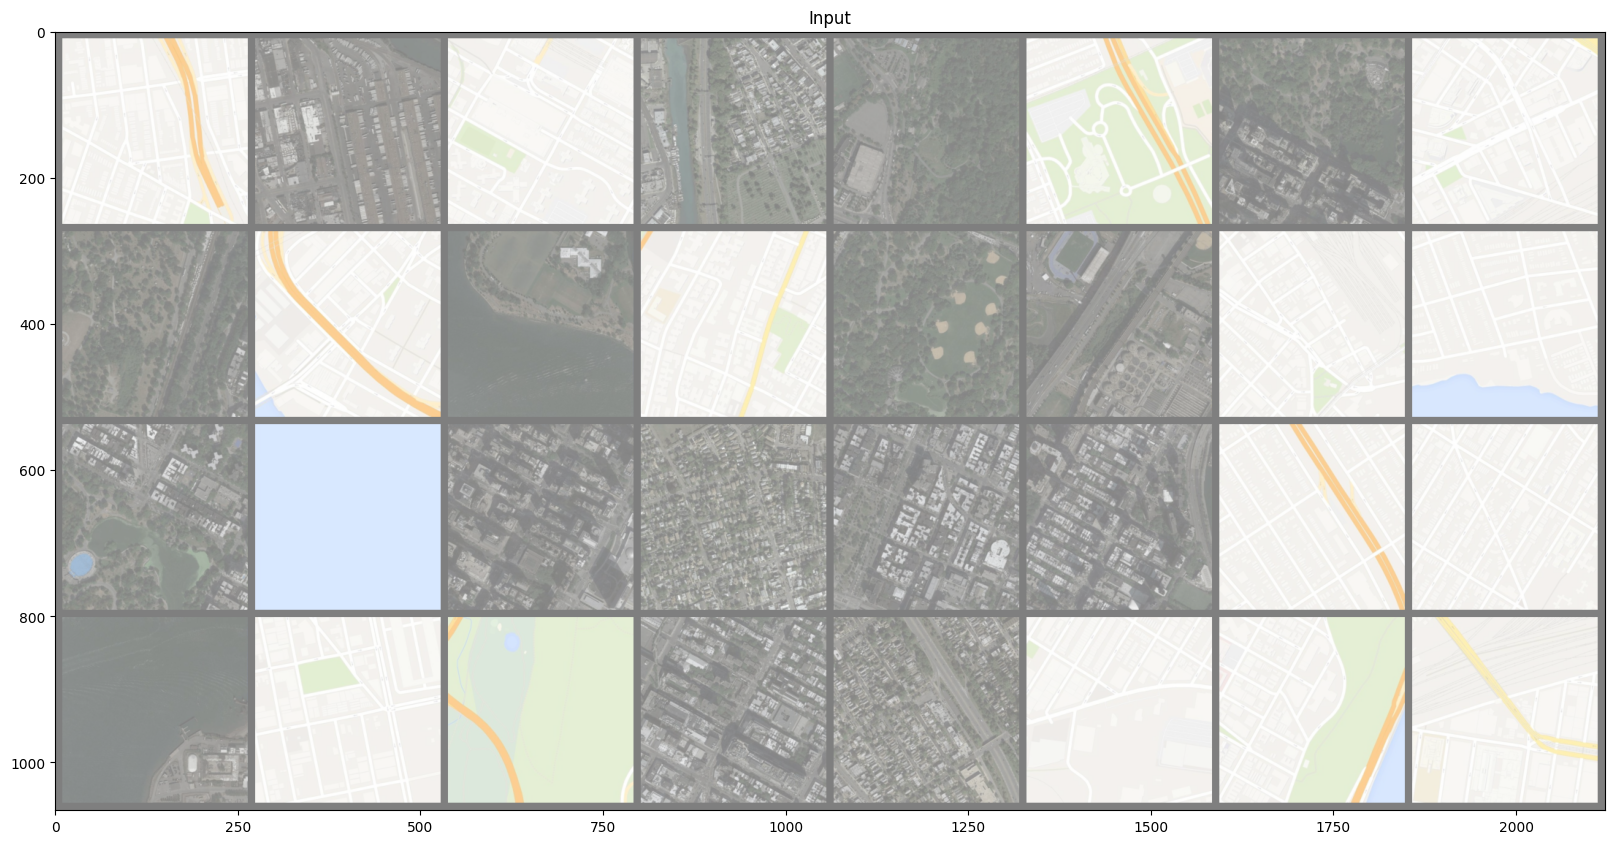

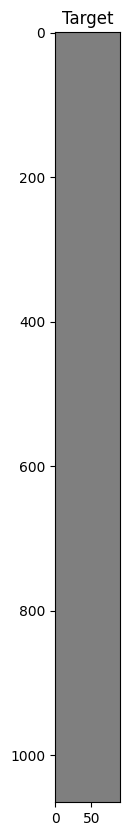

In [246]:
images,_ = next(iter(dataloader_train))
x = torchvision.utils.make_grid(images[:,:,:,:256], padding=10)
y = torchvision.utils.make_grid(images[:,:,:,256:], padding=10)

show_image(x, title="Input", figsize=(20,20))
show_image(y, title="Target", figsize=(10,10))

In [247]:
def weights_init(m):
    name = m.__class__.__name__

    if(name.find("Conv") > -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02) # ~N(mean=0.0, std=0.02)
    elif(name.find("BatchNorm") > -1):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [258]:
# Generator
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu

        self.encoder1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False)
        self.encoder2 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128)
        )
        # Remaining encoder layers

        self.encoder7 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False)
        )

        self.decoder1 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5)
        )
        # Remaining decoder layers

        self.decoder7 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=64*2, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        # Remaining encoder layers

        latent_space = self.encoder7(e6)

        d1 = torch.cat([self.decoder1(latent_space), e6], dim=1)
        # Remaining decoder layers

        out = self.decoder7(d6)

        return out

In [249]:
model_G = Generator(ngpu=1)

if(device == "cuda" and ngpu > 1):
    model_G = nn.DataParallel(model_G, list(range(ngpu)))

model_G.apply(weights_init)
model_G.to(device)

Generator(
  (encoder1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (encoder2): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder3): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder4): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder5): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(512, 512, kernel_s

In [259]:
model_G.to(device)
#model_G(images[:,:,:,:256]).shape

Generator(
  (encoder1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (encoder2): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder3): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder4): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder5): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(512, 512, kernel_s

In [260]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu

        self.structure = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=64, out_channels= 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.structure(x)


In [261]:
model_D = Discriminator(ngpu=1)

if(device == "cuda" and ngpu>1):
    model_D = torch.DataParallel(model_D, list(rang(ngpu)))

model_D.apply(weights_init)
model_D.to(device)

Discriminator(
  (structure): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [264]:
criterion = nn.MSELoss()  # Using Mean Squared Error (MSE) loss

# Now you can use the criterion in your code
out1 = model_D(images.to(device))
out2 = torch.ones_like(out1, device=device)

print(out1.shape)
loss = criterion(out1, out2)
print(loss)


torch.Size([32, 1, 29, 29])
tensor(0.3584, grad_fn=<MseLossBackward0>)


In [265]:
print(images[:,:,:,:256].shape)
print(images[:,:,:,:].shape)


torch.Size([32, 3, 254, 254])
torch.Size([32, 3, 254, 254])


In [266]:
criterion = nn.BCELoss()

optimizerD = optim.Adam(model_D.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(model_G.parameters(), lr=lr, betas=(beta1, beta2))

NUM_EPOCHS=171
model_D.to(device)
model_G.to(device)
print()

In [267]:
L1_lambda = 100
NUM_EPOCHS= 50

In [287]:
for epoch in range(NUM_EPOCHS + 1):
    print(f"Training epoch {epoch + 1}")
    for images, _ in dataloader_train:
        # ========= Train Discriminator ===========
        # Train on real data
        # Maximize log(D(x,y)) <- maximize D(x,y)
        model_D.zero_grad()

        inputs = images[:, :, :, :224].to(device)  # input image data
        targets = images[:, :, :, :224].to(device)  # real targets data
        real_data = torch.cat([inputs, targets], dim=2).to(device)
        outputs = model_D(real_data)  # label "real" data
        labels = torch.ones_like(outputs, device=device)
        print(inputs.shape)
        print(targets.shape)

        lossD_real = 0.5 * criterion(outputs, labels)  # divide the objective by 2 -> slow down D
        lossD_real.backward()

        # Train on fake data
        # Maximize log(1-D(x,G(x))) <- minimize D(x,G(x))
        gens = model_G(inputs).detach()

        fake_data = torch.cat([inputs, gens], dim=1)  # generated image data
        outputs = model_D(fake_data)
        labels = torch.zeros_like(outputs, device=device)  # label "fake" data

        lossD_fake = 0.5 * criterion(outputs, labels)  # divide the objective by 2 -> slow down D
        lossD_fake.backward()

        optimizerD.step()

        # ========= Train Generator x2 times ============
        # maximize log(D(x, G(x)))
        for i in range(2):
            model_G.zero_grad()

            gens = model_G(inputs)

            gen_data = torch.cat([inputs, gens], dim=1)  # concatenated generated data
            outputs = model_D(gen_data)
            labels = torch.ones_like(outputs, device=device)

            lossG = criterion(outputs, labels) + L1_lambda * torch.abs(gens - targets).sum()
            lossG.backward()
            optimizerG.step()

    if epoch % 5 == 0:
        torch.save(model_G, "./sat2mapGen_v1.3.pth")
        torch.save(model_D, "./sat2mapDisc_v1.3.pth")

print("Done!")


Training epoch 1
torch.Size([32, 3, 254, 224])
torch.Size([32, 3, 254, 224])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 2 but got size 3 for tensor number 1 in the list.

In [ ]:
images[:,:,:,224:

In [224]:
show_image(maps, title="Expected Output", figsize=(5,5))

NameError: name 'maps' is not defined

In [225]:
print(model_D(torch.cat([satellite[6,:,:,:].reshape(1,3,256,256).to(device), gen[6,:,:,:].reshape(1,3,256,256).to(device)], dim=1)))

NameError: name 'satellite' is not defined

In [ ]:
torch.save(model_G, "./sat2mapGen_v1.1.pth")
torch.save(model_D, "./sat2mapDisc_v1.1.pth")

In [ ]:
model_G = torch.load("./sat2mapGen_v1.1.pth")

In [ ]:
inp = images[:,:,:,:256]
target = images[:,:,:,256:]

print(inp.shape)
print(target.shape)

In [ ]:
data_real = torch.cat([inp, target], dim=1)
print(data_real.shape)

In [ ]:
transformmm = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [ ]:
datasettt = datasets.ImageFolder(root=os.path.join(data_dir,"train"), transform=transformmm)

In [ ]:
dataloaderrrr = torch.utils.data.DataLoader(datasettt, batch_size=1, shuffle=True, num_workers=0)

In [ ]:
imgsss,_ = next(iter(dataloaderrrr))
show_image(imgsss[0,:,:,:])

In [ ]:
name = "TransposeConv2d"
print(name.find("Conv"))

In [ ]:
a = torch.ones(size=(8,3,5,5))
b = torch.zeros(size=(8,3,5,5))

torch.abs(a-b).sum()